In [99]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()
# Add the ./src folder to the Python module search path
sys.path.append(os.path.join(current_dir, '..', 'src'))

from train_test import *
from utils import *
from optimize import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


from scipy import stats
from scipy.optimize import minimize
from scipy.stats import pearsonr
from scipy.stats import ks_2samp


import xgboost as xgb


sns.set_style('ticks')

### 1. read sparse and dense best feature sets

In [100]:
input_path = '../Data/'

# Seleted Mordred Descriptors
features_file_1 = 'featureSelection/selection_cleanMordredDescriptors.csv'
# Full deepnose updated features 
features_file_2 =  'deepnose_features_UPD.npy'

# Morgan fingerprint 50 dimension
features_file_3 = 'Fingerprints/Morgan_Fingerprints_Frequency_Size50.csv'
# Full leffingwell updated features, absent molecules filled with deepnose predictions
features_file_4 =  'leffingwell_features_98_UPD.npy'

# Mapping helper files
CID_file = 'molecules_train_cid.npy'
training_task_file = 'TrainingData_mixturedist.csv'

features_CIDs = np.load(os.path.join(input_path, CID_file))
mixtures_IDs = pd.read_csv(os.path.join(input_path, mixture_file))

# Dense features
features_1 = pd.read_csv(os.path.join(input_path, features_file_1), index_col= 0)
features_2 = np.load(os.path.join(input_path, features_file_2))


# Sparse features
features_3 = pd.read_csv(os.path.join(input_path, features_file_3), index_col= 0)
features_4 = np.load(os.path.join(input_path, features_file_4))

In [101]:
# Transform dense features:
scaler = StandardScaler(with_mean=True, with_std=True)

# Standardize Mordred
features_1_np = scaler.fit_transform(features_1)
features_1 = pd.DataFrame(features_1_np, columns=features_1.columns, index=features_1.index)

# Log standardize Deepnose
scaler = StandardScaler(with_mean=True, with_std=True)
epsilon = 1e-8 
features_2 = scaler.fit_transform(np.log(features_2 + epsilon))

In [102]:
# Map CID to features:

# Dense
CID2features_deepnose=  {CID: features_2[i] for i, CID in enumerate(features_CIDs)}
CID2features_mordred =  {CID: features_1.loc[CID].tolist() for CID in features_CIDs}

# Sparse
CID2features_morgan =  {CID: features_3.loc[CID].tolist() for CID in features_CIDs}
CID2features_leffingwell = {CID: features_4[i] for i, CID in enumerate(features_CIDs)}

In [103]:
features_list_dense = [CID2features_mordred, CID2features_deepnose]
features_list_sparse = [CID2features_morgan, CID2features_leffingwell]

In [104]:
# Training set for leaderboard
X_dense_train, y_true_train = stacking_X_features(features_list_dense, "avg", "training")
X_sparse_train, _ = stacking_X_features(features_list_sparse, "avg", "training")  # was 'sum', but maybe avg helps make RF/GB meta models more stable?

# Training set + leaderboard set, for test
X_dense_all, y_true_all = stacking_X_features(features_list_dense, "avg", "all")
X_sparse_all, _ = stacking_X_features(features_list_sparse, "avg", "all")

# Leaderboard test set
X_dense_leaderboard, y_true_leaderboard = stacking_X_test_features(features_list_dense,  X_dense_train, "avg", "leaderboard")
X_sparse_leaderboard, _ = stacking_X_test_features(features_list_sparse,  X_sparse_train, "avg",  "leaderboard")

# Test test set
X_dense_test, _ = stacking_X_test_features(features_list_dense,  X_dense_all, "avg", "test")
X_sparse_test, _ = stacking_X_test_features(features_list_sparse,  X_sparse_all, "avg",  "test")

### 2. Training with sparse, dense and different meta models over sparse and dense predictions

Sainity check - at least combo model should not have very different performance than base model (esp. Dense features)

In [105]:
n_folds = 10
seed = 314159

# This is obtained from training individual models:
best_rf_dense = {'n_estimators': 500, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
best_rf_sparse = {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 30, 'bootstrap': True}

In [106]:
def evaluate_fold(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    corr, _ = pearsonr(y_true, y_pred)
    return rmse, corr

def stacking_ensemble_cv(X_dense, X_sparse, y, base_model_dense, base_model_sparse, meta_models, n_folds=10):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    dense_preds = np.zeros(len(y))
    sparse_preds = np.zeros(len(y))
    meta_preds = {name: np.zeros(len(y)) for name in meta_models.keys()}
    
    fold_results = {
        'dense_model': {'RMSE': [], 'Correlation': []},
        'sparse_model': {'RMSE': [], 'Correlation': []}
    }
    for name in meta_models.keys():
        fold_results[f'stacked_model_{name}'] = {'RMSE': [], 'Correlation': []}
    
    for train_index, val_index in kf.split(X_dense):
        X_dense_train, X_dense_val = X_dense[train_index], X_dense[val_index]
        X_sparse_train, X_sparse_val = X_sparse[train_index], X_sparse[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Train and predict with base models
        base_model_dense.fit(X_dense_train, y_train)
        base_model_sparse.fit(X_sparse_train, y_train)
        
        dense_preds[val_index] = base_model_dense.predict(X_dense_val)
        sparse_preds[val_index] = base_model_sparse.predict(X_sparse_val)
        
        # Evaluate base models for this fold
        rmse, corr = evaluate_fold(y_val, dense_preds[val_index])
        fold_results['dense_model']['RMSE'].append(rmse)
        fold_results['dense_model']['Correlation'].append(corr)
        
        rmse, corr = evaluate_fold(y_val, sparse_preds[val_index])
        fold_results['sparse_model']['RMSE'].append(rmse)
        fold_results['sparse_model']['Correlation'].append(corr)
        
        # Train and predict with meta models
        meta_features_train = np.column_stack((
            base_model_dense.predict(X_dense_train),
            base_model_sparse.predict(X_sparse_train)
        ))
        meta_features_val = np.column_stack((dense_preds[val_index], sparse_preds[val_index]))
        
        for name, meta_model in meta_models.items():
            meta_model.fit(meta_features_train, y_train)
            meta_preds[name][val_index] = meta_model.predict(meta_features_val)
            
            # Evaluate meta model for this fold
            rmse, corr = evaluate_fold(y_val, meta_preds[name][val_index])
            fold_results[f'stacked_model_{name}']['RMSE'].append(rmse)
            fold_results[f'stacked_model_{name}']['Correlation'].append(corr)
    
    # Calculate overall performance
    overall_results = {
        'dense_model': {'RMSE': np.sqrt(mean_squared_error(y, dense_preds)),
                        'Correlation': pearsonr(y, dense_preds)[0]},
        'sparse_model': {'RMSE': np.sqrt(mean_squared_error(y, sparse_preds)),
                         'Correlation': pearsonr(y, sparse_preds)[0]}
    }
    
    for name in meta_models.keys():
        overall_results[f'stacked_model_{name}'] = {
            'RMSE': np.sqrt(mean_squared_error(y, meta_preds[name])),
            'Correlation': pearsonr(y, meta_preds[name])[0]
        }
    
    return {'performance': overall_results, 'fold_results': fold_results}

def visualize_fold_results(fold_results):
    num_models = len(fold_results)
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    for ax, metric in zip(axes, ['RMSE', 'Correlation']):
        for i, (model_name, results) in enumerate(fold_results.items()):
            values = results[metric]
            ax.plot(range(1, len(values) + 1), values, marker='o', label=model_name)
        
        ax.set_xlabel('Fold')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} across folds')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

In [107]:
# Define base models
base_model_dense = RandomForestRegressor(**best_rf_dense, random_state=seed)
base_model_sparse = RandomForestRegressor(**best_rf_sparse, random_state=seed)

# Define meta models
meta_models = {
    'Ridge': Ridge(),
    'Poly_Ridge': make_pipeline(PolynomialFeatures(degree=2), Ridge()),
    'RF': RandomForestRegressor(random_state=seed),
    'GB': GradientBoostingRegressor(random_state=seed),
    'KNN': KNeighborsRegressor()
}


# Run cross-validation
cv_results = stacking_ensemble_cv(X_dense_train, X_sparse_train, y_true_train, base_model_dense, base_model_sparse, meta_models)

# Print overall results
print("Overall Cross-validation Performance:")
for model, performance in cv_results['performance'].items():
    print(f"{model}:")
    print(f"  RMSE: {performance['RMSE']:.4f}")
    print(f"  Correlation: {performance['Correlation']:.4f}")
    print()

Overall Cross-validation Performance:
dense_model:
  RMSE: 0.1226
  Correlation: 0.6381

sparse_model:
  RMSE: 0.1248
  Correlation: 0.6044

stacked_model_Ridge:
  RMSE: 0.1209
  Correlation: 0.6350

stacked_model_Poly_Ridge:
  RMSE: 0.1206
  Correlation: 0.6388

stacked_model_RF:
  RMSE: 0.1207
  Correlation: 0.6364

stacked_model_GB:
  RMSE: 0.1209
  Correlation: 0.6350

stacked_model_KNN:
  RMSE: 0.1212
  Correlation: 0.6332



In [108]:
def calculate_fold_means(fold_results):
    mean_results = {}
    for model, metrics in fold_results.items():
        mean_results[model] = {
            'Mean RMSE': np.mean(metrics['RMSE']),
            'Std RMSE': np.std(metrics['RMSE']),
            'Mean Correlation': np.mean(metrics['Correlation']),
            'Std Correlation': np.std(metrics['Correlation'])
        }
    return mean_results

def print_fold_means(mean_results):
    print("Mean Performance Across Folds:")
    for model, metrics in mean_results.items():
        print(f"\n{model}:")
        print(f"  RMSE: {metrics['Mean RMSE']:.4f} ± {metrics['Std RMSE']:.4f}")
        print(f"  Correlation: {metrics['Mean Correlation']:.4f} ± {metrics['Std Correlation']:.4f}")

# Print and visualize per fold performance as well
fold_means = calculate_fold_means(cv_results['fold_results'])
print_fold_means(fold_means)

Mean Performance Across Folds:

dense_model:
  RMSE: 0.1220 ± 0.0128
  Correlation: 0.6371 ± 0.1017

sparse_model:
  RMSE: 0.1241 ± 0.0128
  Correlation: 0.6023 ± 0.1118

stacked_model_Ridge:
  RMSE: 0.1202 ± 0.0134
  Correlation: 0.6318 ± 0.1010

stacked_model_Poly_Ridge:
  RMSE: 0.1199 ± 0.0131
  Correlation: 0.6366 ± 0.0978

stacked_model_RF:
  RMSE: 0.1199 ± 0.0144
  Correlation: 0.6373 ± 0.0993

stacked_model_GB:
  RMSE: 0.1199 ± 0.0155
  Correlation: 0.6357 ± 0.1067

stacked_model_KNN:
  RMSE: 0.1204 ± 0.0138
  Correlation: 0.6328 ± 0.0975


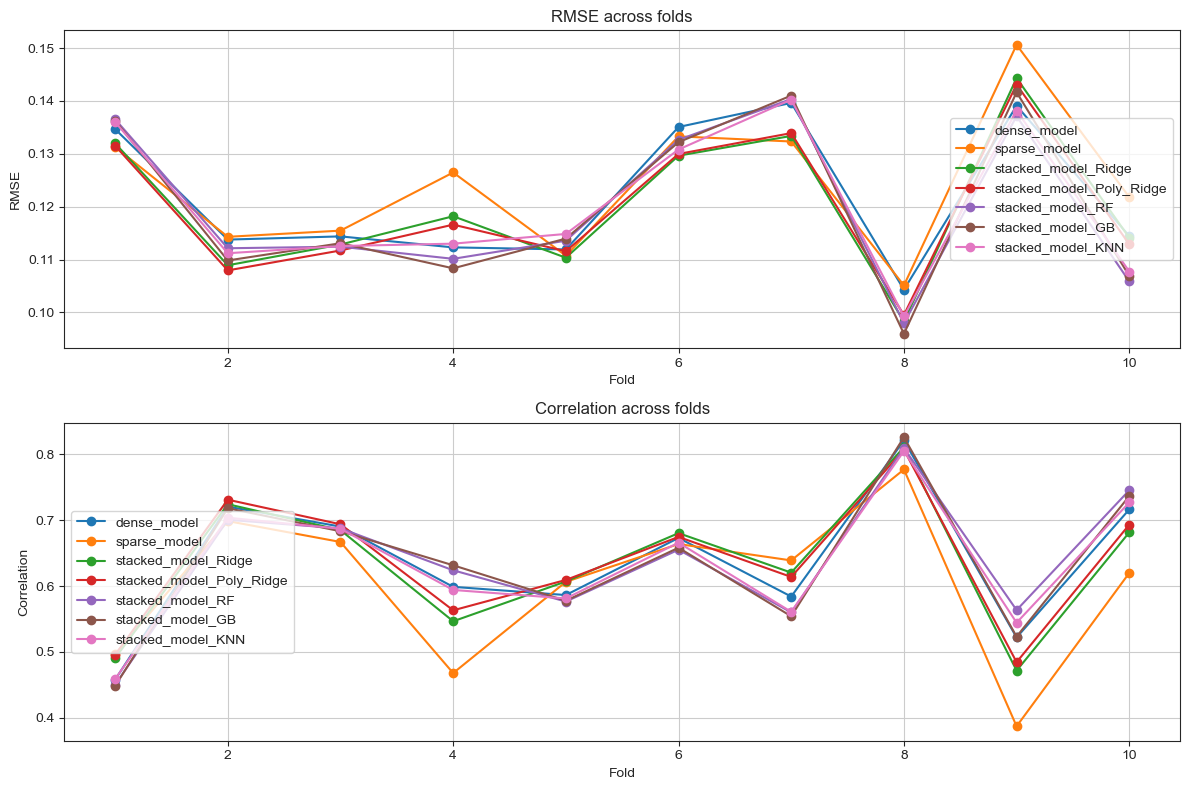

In [109]:
# Visualize fold results
visualize_fold_results(cv_results['fold_results'])

### 3. Train final models

Here we train two final models, without and with leaderboard augmentation.

In [110]:
def train_final_models(X_dense, X_sparse, y, base_model_dense_class, base_model_sparse_class, meta_models, n_models=1):
    final_models = {name: [] for name in meta_models.keys()}
    
    for seed in range(n_models):
        base_model_dense = base_model_dense_class(**best_rf_dense, random_state=seed)
        base_model_sparse = base_model_sparse_class(**best_rf_sparse, random_state=seed)
        
        # Train base models
        final_base_model_dense = base_model_dense.fit(X_dense, y)
        final_base_model_sparse = base_model_sparse.fit(X_sparse, y)
        
        # Train meta models
        final_meta_features = np.column_stack((
            final_base_model_dense.predict(X_dense),
            final_base_model_sparse.predict(X_sparse)
        ))
        
        for name, meta_model_class in meta_models.items():
            if name == 'Poly_Ridge':
                meta_model = meta_model_class.fit(final_meta_features, y)
            elif name == 'KNN':
                meta_model = meta_model_class().fit(final_meta_features, y)
            else:
                meta_model = meta_model_class(random_state=seed).fit(final_meta_features, y)
            final_models[name].append((final_base_model_dense, final_base_model_sparse, meta_model))
    
    return final_models


def predict_stacked_ensemble(X_dense_new, X_sparse_new, final_models):
    predictions = {name: [] for name in final_models.keys()}
    
    for name, models in final_models.items():
        for dense_model, sparse_model, meta_model in models:
            dense_pred = dense_model.predict(X_dense_new)
            sparse_pred = sparse_model.predict(X_sparse_new)
            meta_features = np.column_stack((dense_pred, sparse_pred))
            meta_pred = meta_model.predict(meta_features)
            predictions[name].append(meta_pred)
    
    return {name: np.mean(preds, axis=0) for name, preds in predictions.items()}

def evaluate_performance(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    corr, _ = pearsonr(y_true, y_pred)
    return rmse, corr


In [111]:
def predict_base_models(X_dense_new, X_sparse_new, final_models):
    base_predictions = {'dense': [], 'sparse': []}
    
    for _, models in final_models.items():
        for dense_model, sparse_model, meta_model in models:
            dense_pred = dense_model.predict(X_dense_new)
            sparse_pred = sparse_model.predict(X_sparse_new)
            
            base_predictions['dense'].append(dense_pred)
            base_predictions['sparse'].append(sparse_pred)


    # Calculate mean predictions for base models
    base_predictions_mean = {
        'dense': np.mean(base_predictions['dense'], axis=0),
        'sparse': np.mean(base_predictions['sparse'], axis=0)
    }
    
    return base_predictions, base_predictions_mean

In [112]:
# Define meta-models, a bit different from cv, as here random state and other argument are specified within the loop
meta_models = {
    'Ridge': Ridge,
    'Poly_Ridge': make_pipeline(PolynomialFeatures(degree=2), Ridge()),
    'RF': RandomForestRegressor,
    'GB': GradientBoostingRegressor,
    'KNN': KNeighborsRegressor
}

In [113]:
# Train final models
final_models = train_final_models(X_dense_train, X_sparse_train, y_true_train, RandomForestRegressor, RandomForestRegressor, meta_models)
final_models_aug = train_final_models(X_dense_all, X_sparse_all, y_true_all, RandomForestRegressor, RandomForestRegressor, meta_models)

# Evaluate on training data
train_predictions = predict_stacked_ensemble(X_dense_train, X_sparse_train, final_models)
train_predictions_aug =  predict_stacked_ensemble(X_dense_all, X_sparse_all, final_models_aug)

In [114]:
print("Training on Training Set Performance:")
print()
for name, preds in train_predictions.items():
    rmse, corr = evaluate_performance(y_true_train, preds)
    print(f"{name} - RMSE: {rmse:.4f}, Correlation: {corr:.4f}")
print()

print("Training on Training + Leaderbarod Performance:")
print()
for name, preds in train_predictions_aug.items():
    rmse, corr = evaluate_performance(y_true_all, preds)
    print(f"{name} - RMSE: {rmse:.4f}, Correlation: {corr:.4f}")

Training on Training Set Performance:

Ridge - RMSE: 0.0347, Correlation: 0.9773
Poly_Ridge - RMSE: 0.0351, Correlation: 0.9749
RF - RMSE: 0.0124, Correlation: 0.9969
GB - RMSE: 0.0210, Correlation: 0.9910
KNN - RMSE: 0.0260, Correlation: 0.9863

Training on Training + Leaderbarod Performance:

Ridge - RMSE: 0.0349, Correlation: 0.9767
Poly_Ridge - RMSE: 0.0349, Correlation: 0.9753
RF - RMSE: 0.0115, Correlation: 0.9974
GB - RMSE: 0.0208, Correlation: 0.9912
KNN - RMSE: 0.0259, Correlation: 0.9866


### 4. Eval on leaderboard

In [115]:
print("\nLeaderbaord Performance (base models):")
print()

base_predictions, base_predictions_mean = predict_base_models(X_dense_leaderboard, X_sparse_leaderboard, final_models)

for name, preds in base_predictions_mean.items():
    rmse, corr = evaluate_performance(y_true_leaderboard, preds) 
    print(f"{name} - RMSE: {rmse:.4f}, Correlation: {corr:.4f}")


Leaderbaord Performance (base models):

dense - RMSE: 0.1189, Correlation: 0.7260
sparse - RMSE: 0.1257, Correlation: 0.6460


In [116]:
print("\nLeaderbaord Performance (meta models):")
print()
# Evaluate on test data
leaderboard_predictions = predict_stacked_ensemble(X_dense_leaderboard, X_sparse_leaderboard, final_models)

for name, preds in leaderboard_predictions.items():
    rmse, corr = evaluate_performance(y_true_leaderboard, preds)
    print(f"{name} - RMSE: {rmse:.4f}, Correlation: {corr:.4f}")


Leaderbaord Performance (meta models):

Ridge - RMSE: 0.1181, Correlation: 0.6995
Poly_Ridge - RMSE: 0.1189, Correlation: 0.6985
RF - RMSE: 0.1112, Correlation: 0.7432
GB - RMSE: 0.1126, Correlation: 0.7353
KNN - RMSE: 0.1149, Correlation: 0.7166


#### Visualizing leaderboard:

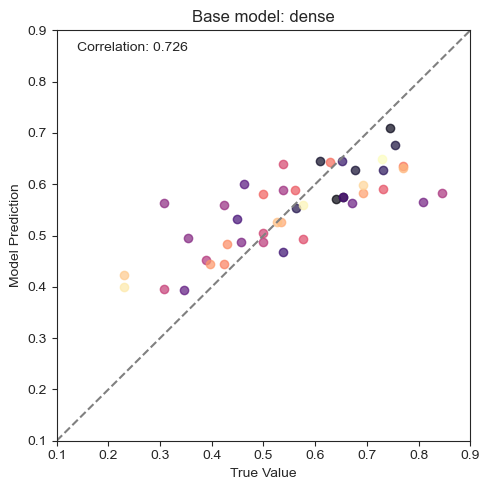

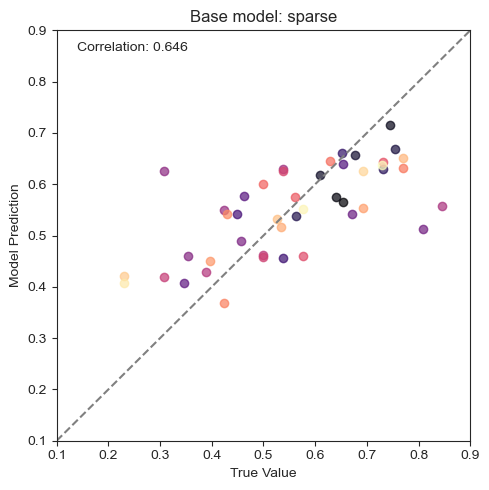

In [117]:
# Color map for all data points
num_points = len(base_predictions_mean[list(base_predictions_mean.keys())[0]])
colors = plt.cm.magma(np.linspace(0, 1, num_points))

for base_model in base_predictions_mean.keys():
    plt.figure(figsize=(5, 5))
    
    # Use the same color for each point across all plots
    for i in range(num_points):
        plt.scatter(y_true_leaderboard[i], 
                    base_predictions_mean[base_model][i], 
                    color=colors[i], 
                    alpha=0.7)

    plt.xlim(.1, .9)
    plt.ylim(.1, .9)
    plt.xlabel('True Value')
    plt.ylabel('Model Prediction')
    plt.title(f'Base model: {base_model}')
    
    # Add y=x line
    plt.plot([.1, .9], [.1, .9], color='grey', linestyle='--')

    # Calculate and add correlation
    correlation, _ = stats.pearsonr(y_true_leaderboard, base_predictions_mean[base_model])
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

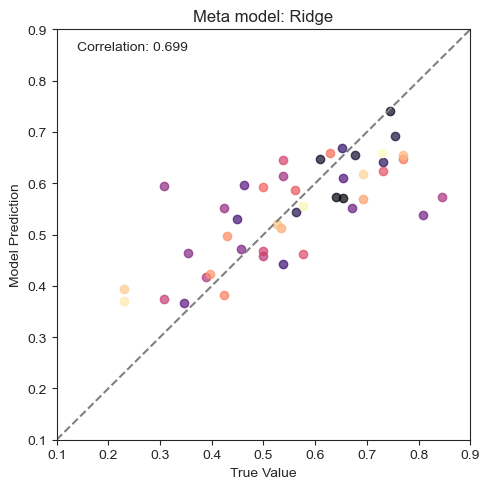

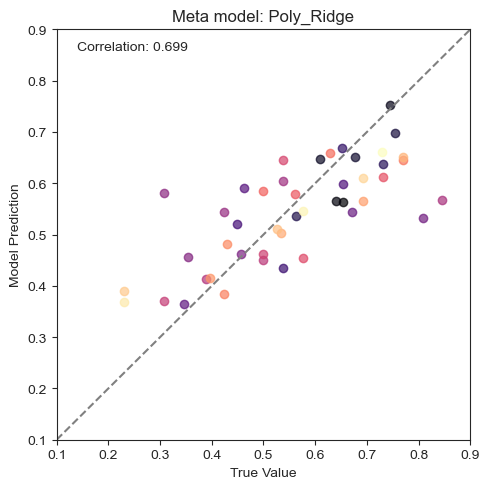

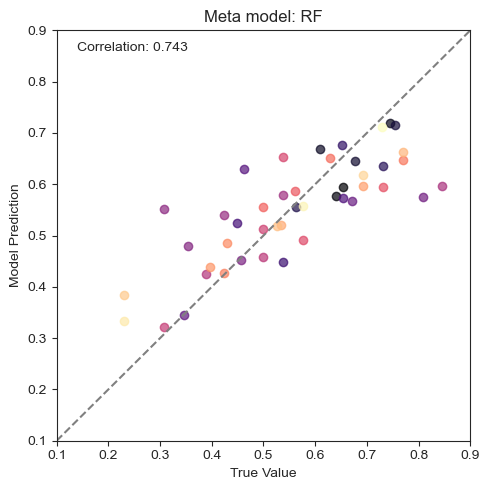

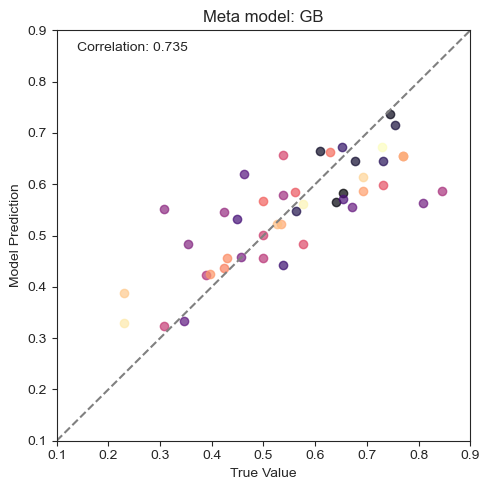

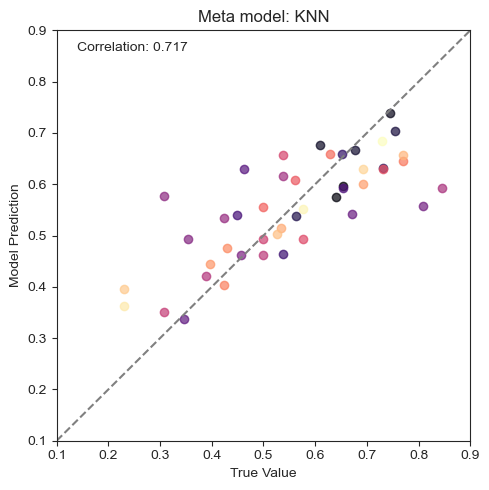

In [118]:
# Color map for all data points
num_points = len(leaderboard_predictions[list(leaderboard_predictions.keys())[0]])
colors = plt.cm.magma(np.linspace(0, 1, num_points))

for meta_model in leaderboard_predictions.keys():
    plt.figure(figsize=(5, 5))
    
    # Use the same color for each point across all plots
    for i in range(num_points):
        plt.scatter(y_true_leaderboard[i], 
                    leaderboard_predictions[meta_model][i], 
                    color=colors[i], 
                    alpha=0.7)

    plt.xlim(.1, .9)
    plt.ylim(.1, .9)
    plt.xlabel('True Value')
    plt.ylabel('Model Prediction')
    plt.title(f'Meta model: {meta_model}')
    
    # Add y=x line
    plt.plot([.1, .9], [.1, .9], color='grey', linestyle='--')

    # Calculate and add correlation
    correlation, _ = stats.pearsonr(y_true_leaderboard, leaderboard_predictions[meta_model])
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

### 5. Compare correaltion of final models trained with and without leaderboard data

In [119]:
test_predictions = predict_stacked_ensemble(X_dense_test, X_sparse_test, final_models)
test_predictions_aug = predict_stacked_ensemble(X_dense_test, X_sparse_test, final_models_aug)

#### Visualizing Test:

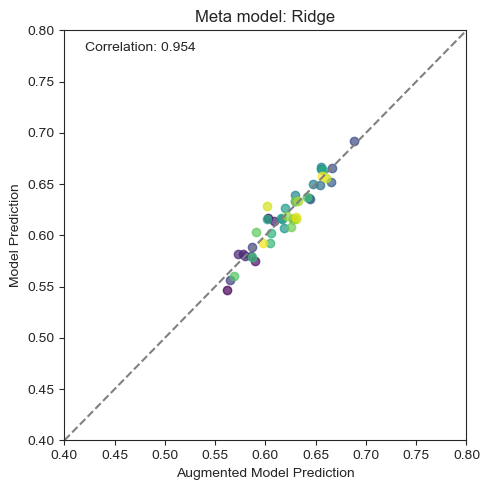

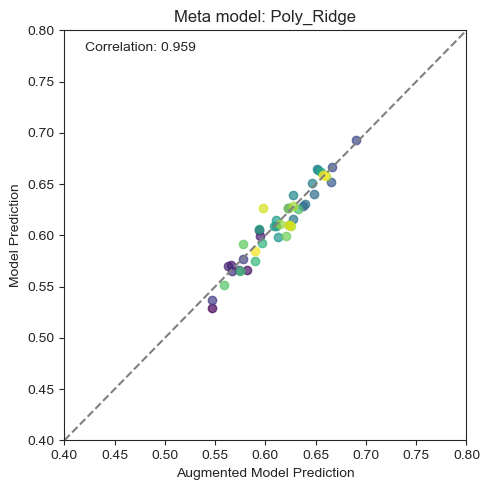

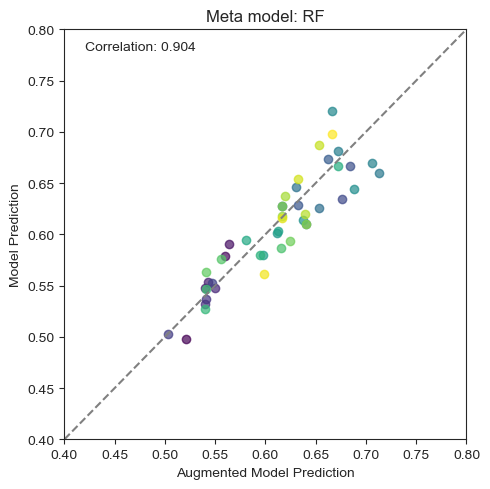

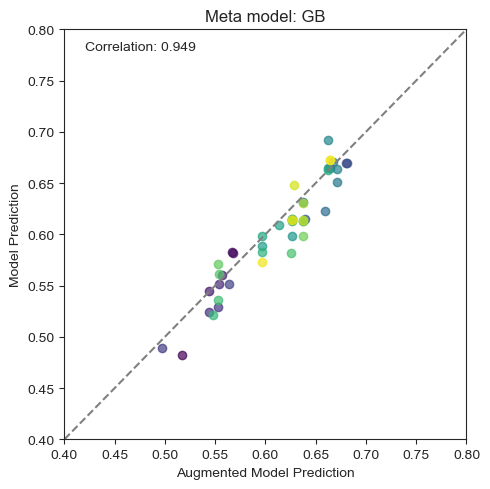

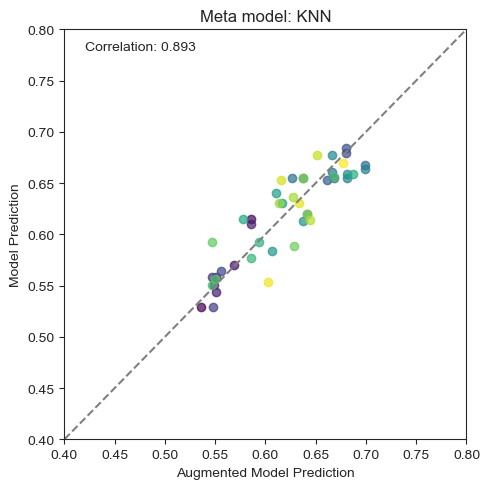

In [120]:
# Color map for all data points
num_points = len(test_predictions[list(test_predictions.keys())[0]])
colors = plt.cm.viridis(np.linspace(0, 1, num_points))

for meta_model in test_predictions.keys():
    plt.figure(figsize=(5, 5))
    
    # Use the same color for each point across all plots
    for i in range(num_points):
        plt.scatter(test_predictions_aug[meta_model][i], 
                    test_predictions[meta_model][i], 
                    color=colors[i], 
                    alpha=0.7)

    plt.xlim(.4, .8)
    plt.ylim(.4, .8)
    plt.xlabel('Augmented Model Prediction')
    plt.ylabel('Model Prediction')
    plt.title(f'Meta model: {meta_model}')
    
    # Add y=x line
    plt.plot([.4, .8], [.4, .8], color='grey', linestyle='--')

    # Calculate and add correlation
    correlation, _ = stats.pearsonr(test_predictions_aug[meta_model], test_predictions[meta_model])
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

In [121]:
def create_submission_files(meta_model, out_folder):
    # Read to be filled out form
    leaderboards_submission_form = pd.read_csv('../Test/Submission/Leaderboard_set_Submission_form.csv', index_col = 0)
    test_submission_form = pd.read_csv('../Test/Submission/Test_set_Submission_form.csv', index_col = 0)
    print(f'Test_submission_form created for {meta_model}')
    
    # Write prediction column
    # Use model trained on training
    leaderboards_submission_form['Predicted_Experimental_Values'] = leaderboard_predictions[meta_model] 
    # Use model trained on training + Leaderboard
    test_submission_form['Predicted_Experimental_Values'] = test_predictions_aug[meta_model] 
    print(f'Leaderboard_submission_form created for {meta_model}')

    leaderboards_submission_form.to_csv(f'../Test/Submission/{out_folder}/Leaderboard_set_Submission_form_{meta_model}.csv')
    test_submission_form.to_csv(f'../Test/Submission/{out_folder}/Test_set_Submission_form_{meta_model}.csv')

In [122]:
meta_model = 'RF'
out_folder = 'Meta_072824'

In [123]:
create_submission_files(meta_model, out_folder)

Test_submission_form created for RF
Leaderboard_submission_form created for RF
